A demo using machine larning to predict laptop prices.
Also demonstrated: data processing, etc.

Source:
https://www.kaggle.com/datasets/muhammetvarl/laptop-price

The ML model will be a random decision forest using laptop specs to predict price. 

In [36]:
import pandas as pd 
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor

In [2]:
# The optional arg. 'encoding' is necessary here
df = pd.read_csv("laptop_price.csv", encoding='latin-1')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1303 entries, 0 to 1302
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   laptop_ID         1303 non-null   int64  
 1   Company           1303 non-null   object 
 2   Product           1303 non-null   object 
 3   TypeName          1303 non-null   object 
 4   Inches            1303 non-null   float64
 5   ScreenResolution  1303 non-null   object 
 6   Cpu               1303 non-null   object 
 7   Ram               1303 non-null   object 
 8   Memory            1303 non-null   object 
 9   Gpu               1303 non-null   object 
 10  OpSys             1303 non-null   object 
 11  Weight            1303 non-null   object 
 12  Price_euros       1303 non-null   float64
dtypes: float64(2), int64(1), object(10)
memory usage: 132.5+ KB


Presently, values in key metrics such as "ScreenResolution" are essentially strings.
These values need to be processed and encoded to be used in a regression.

In [4]:
df.ScreenResolution

0               IPS Panel Retina Display 2560x1600
1                                         1440x900
2                                Full HD 1920x1080
3               IPS Panel Retina Display 2880x1800
4               IPS Panel Retina Display 2560x1600
                           ...                    
1298     IPS Panel Full HD / Touchscreen 1920x1080
1299    IPS Panel Quad HD+ / Touchscreen 3200x1800
1300                                      1366x768
1301                                      1366x768
1302                                      1366x768
Name: ScreenResolution, Length: 1303, dtype: object

In [5]:
df.Company.value_counts()

Company
Dell         297
Lenovo       297
HP           274
Asus         158
Acer         103
MSI           54
Toshiba       48
Apple         21
Samsung        9
Razer          7
Mediacom       7
Microsoft      6
Xiaomi         4
Vero           4
Chuwi          3
Google         3
Fujitsu        3
LG             3
Huawei         2
Name: count, dtype: int64

We will encode values in "Company", "TypeName", etc.

We Will drop other values such as those in "Product".


Values in "Company" will be extracted into Boolean variables, for example, if the value is Apple branded or not, etc. Values in the other variable mentioned will be encoded similarly.

We encode values into Boolean representations with the goal in mind of making a decision-tree. We do not use an ordinal encoding for these values because the Companies, for example, do not sensibly fit into an ordered scale. It is not the case that Apple>Microsoft>Google>... this does not make sense numerically. Apple is not 'closer' to Microsoft than it is to Google, etc.

In [6]:
df = df.drop("Product", axis=1)

In [7]:

# "Company", "TypeName", "OpSys"

df = df.join(pd.get_dummies(df.Company))
df = df.drop("Company", axis=1)

df = df.join(pd.get_dummies(df.TypeName))
df = df.drop("TypeName", axis=1)

df = df.join(pd.get_dummies(df.OpSys))
df = df.drop("OpSys", axis=1)


In [8]:
# "Gpu"

df["GPU_Brand"] = df.Gpu.str.split(" ").apply(lambda x: x[0])
GPU_categories = pd.get_dummies(df.GPU_Brand)
GPU_categories.columns = [col + "_GPU" for col in GPU_categories.columns]
df = df.join(GPU_categories)

df = df.drop("GPU_Brand", axis=1)
df = df.drop("Gpu", axis=1)



In [9]:
# "Cpu"

df["CPU_Brand"] = df.Cpu.str.split(" ").apply(lambda x: x[0])
CPU_categories = pd.get_dummies(df.CPU_Brand)
CPU_categories.columns = [col + "_CPU" for col in CPU_categories.columns]
df = df.join(CPU_categories)

df["CPU_Frequency"] = df.Cpu.str.split(" ").apply(lambda x: x[-1])
df["CPU_Frequency"] = df["CPU_Frequency"].str[:-3]
df["CPU_Frequency"] = df["CPU_Frequency"].astype("float")

df = df.drop("CPU_Brand", axis=1)
df = df.drop("Cpu", axis=1)


In [10]:
# "ScreenResolution"

df["ScreenResolution"] = df.ScreenResolution.str.split(" ").apply(lambda x: x[-1])

df["ScreenWidth"] = df.ScreenResolution.str.split("x").apply(lambda x: x[0])
df["ScreenWidth"] = df["ScreenWidth"].astype("int")

df["ScreenHeight"] = df.ScreenResolution.str.split("x").apply(lambda x: x[1])
df["ScreenHeight"] = df["ScreenHeight"].astype("int")

df = df.drop("ScreenResolution", axis=1)

In [11]:

# "Ram"
df["Ram"] = df["Ram"].str[:-2]
df["Ram"] = df["Ram"].astype("int")

In [12]:
# Values in the new variable "MemoryAmount" are not 'nice.'
# Extracting useful numerical data will require more steps. 

df["MemoryAmount"] = df["Memory"].str.split(" ").apply(lambda x: x[0])

df.MemoryAmount.value_counts()

MemoryAmount
256GB    508
1TB      240
128GB    177
512GB    140
500GB    132
32GB      45
64GB      17
2TB       16
1.0TB     10
16GB      10
180GB      5
240GB      1
8GB        1
508GB      1
Name: count, dtype: int64

In [13]:
def mem_to_MB(mem):
    if "GB" in mem:
        return float(mem[:mem.find("GB")]) * 1000
    elif "TB" in mem:
        return float(mem[:mem.find("TB")]) * 1000000

In [14]:
df["MemoryAmount"] = df["MemoryAmount"].apply(mem_to_MB)

df["MemoryType"] = df["Memory"].str.split(" ").apply(lambda x: x[1])
df = df.join(pd.get_dummies(df["MemoryType"]))

df = df.drop("MemoryType", axis=1)
df = df.drop("Memory", axis=1)

In [15]:
# "Weight" will be converted from [kg] into [lb]

def kg_to_lbs(kg):
    return kg * 2.204623

In [16]:
df["Weight"] = df["Weight"].str[:-2]
df["Weight"] = df["Weight"].astype("float")
df["Weight"] = df["Weight"].apply(kg_to_lbs)

In [17]:
# Finally, "Price_euros" will be converted from [€] EUR to [$] USD

def euro_to_usd(euro):
    '''Conversion rate uses a quick google search for demonstration purposes'''
    return euro * 1.08

# To be really precise and careful, one would not use floats to represent currency,
# as floats can be innaccurate at extreme decimal values (due to memory representation)

In [18]:
df["Price_USD"] = df.Price_euros.apply(euro_to_usd)
df = df.drop("Price_euros", axis=1) 

In [19]:
df.columns

Index(['laptop_ID', 'Inches', 'Ram', 'Weight', 'Acer', 'Apple', 'Asus',
       'Chuwi', 'Dell', 'Fujitsu', 'Google', 'HP', 'Huawei', 'LG', 'Lenovo',
       'MSI', 'Mediacom', 'Microsoft', 'Razer', 'Samsung', 'Toshiba', 'Vero',
       'Xiaomi', '2 in 1 Convertible', 'Gaming', 'Netbook', 'Notebook',
       'Ultrabook', 'Workstation', 'Android', 'Chrome OS', 'Linux', 'Mac OS X',
       'No OS', 'Windows 10', 'Windows 10 S', 'Windows 7', 'macOS', 'AMD_GPU',
       'ARM_GPU', 'Intel_GPU', 'Nvidia_GPU', 'AMD_CPU', 'Intel_CPU',
       'Samsung_CPU', 'CPU_Frequency', 'ScreenWidth', 'ScreenHeight',
       'MemoryAmount', 'Flash', 'HDD', 'Hybrid', 'SSD', 'Price_USD'],
      dtype='object')

<Axes: >

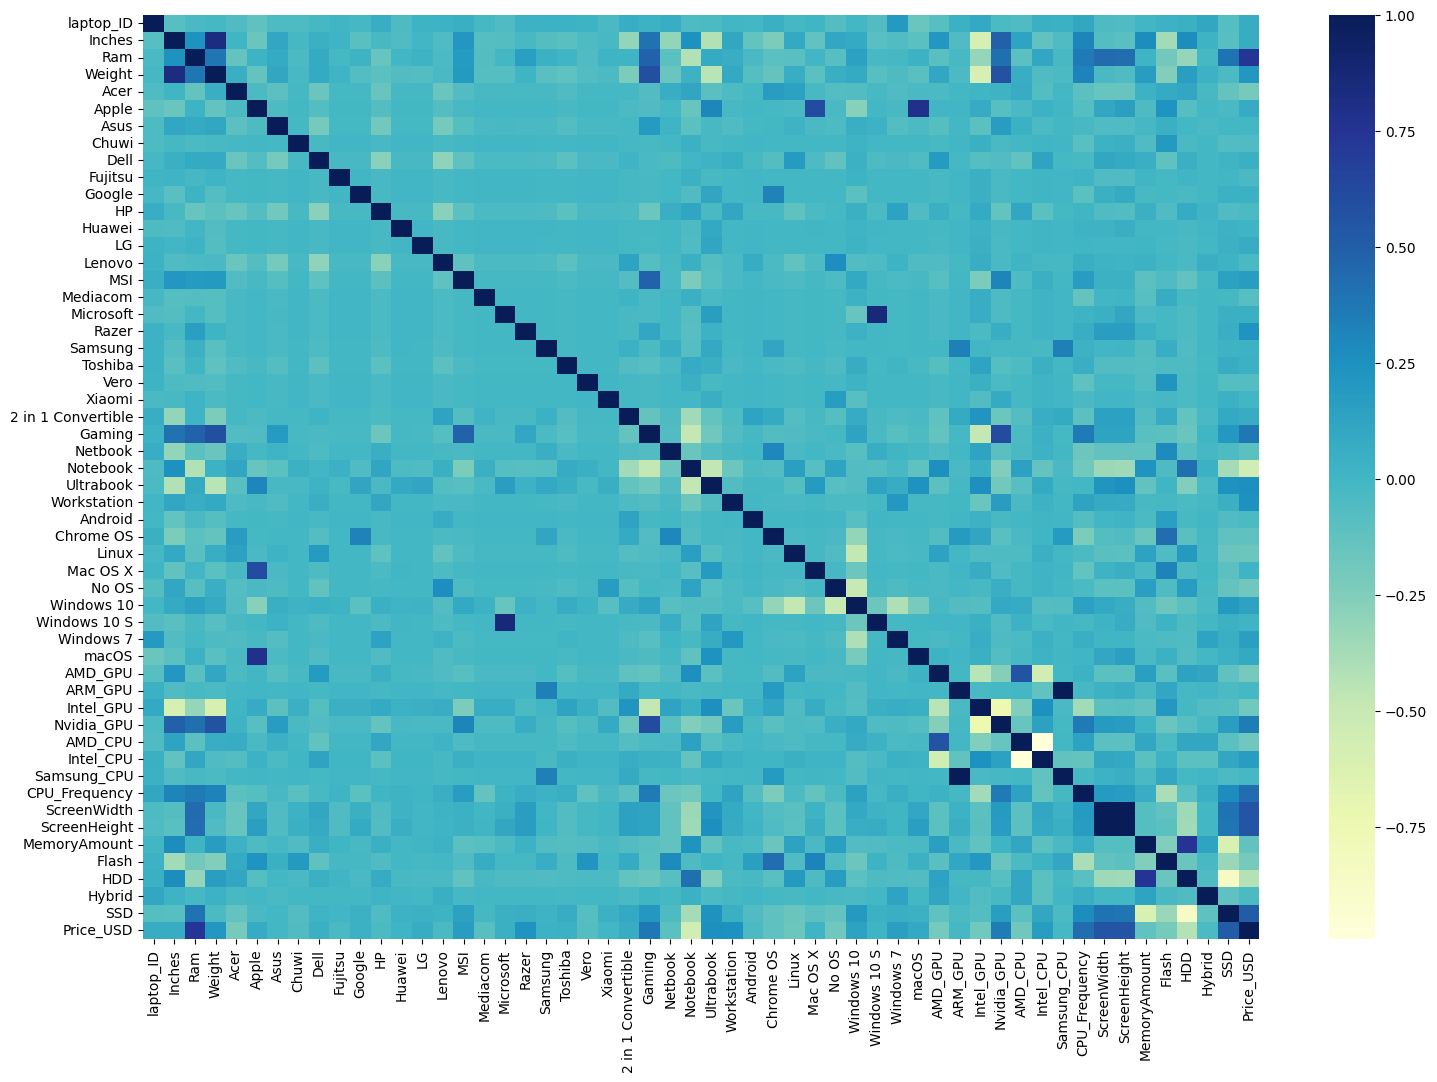

In [21]:
corr_matrix = df.corr()

plt.figure(figsize=(18,12))
sns.heatmap(corr_matrix, annot=False, cmap="YlGnBu")

In [25]:
target_correlations = corr_matrix["Price_USD"].apply(abs).sort_values(ascending=False)
target_correlations

Price_USD             1.000000
Ram                   0.743007
ScreenWidth           0.556529
ScreenHeight          0.552809
Notebook              0.549248
SSD                   0.513609
CPU_Frequency         0.430293
HDD                   0.426121
Gaming                0.375789
Nvidia_GPU            0.348797
Ultrabook             0.255658
Workstation           0.249752
Razer                 0.233756
Flash                 0.210823
Weight                0.210370
Acer                  0.208349
AMD_GPU               0.199415
Intel_GPU             0.184205
Intel_CPU             0.181127
AMD_CPU               0.180111
MSI                   0.180100
No OS                 0.177094
Linux                 0.162060
Windows 7             0.152381
Windows 10            0.137048
MemoryAmount          0.122365
Chrome OS             0.118684
Netbook               0.097572
macOS                 0.089928
Mediacom              0.087161
Apple                 0.080688
2 in 1 Convertible    0.072675
Vero    

In [30]:
# We arbitrarily select the 20 variables with greatest absolute correlation with "Price_USD"

k = 20
selected_correlations = target_correlations[:(k+1)].index
selected_correlations = list(selected_correlations)
selected_correlations

['Price_USD',
 'Ram',
 'ScreenWidth',
 'ScreenHeight',
 'Notebook',
 'SSD',
 'CPU_Frequency',
 'HDD',
 'Gaming',
 'Nvidia_GPU',
 'Ultrabook',
 'Workstation',
 'Razer',
 'Flash',
 'Weight',
 'Acer',
 'AMD_GPU',
 'Intel_GPU',
 'Intel_CPU',
 'AMD_CPU',
 'MSI']

<Axes: >

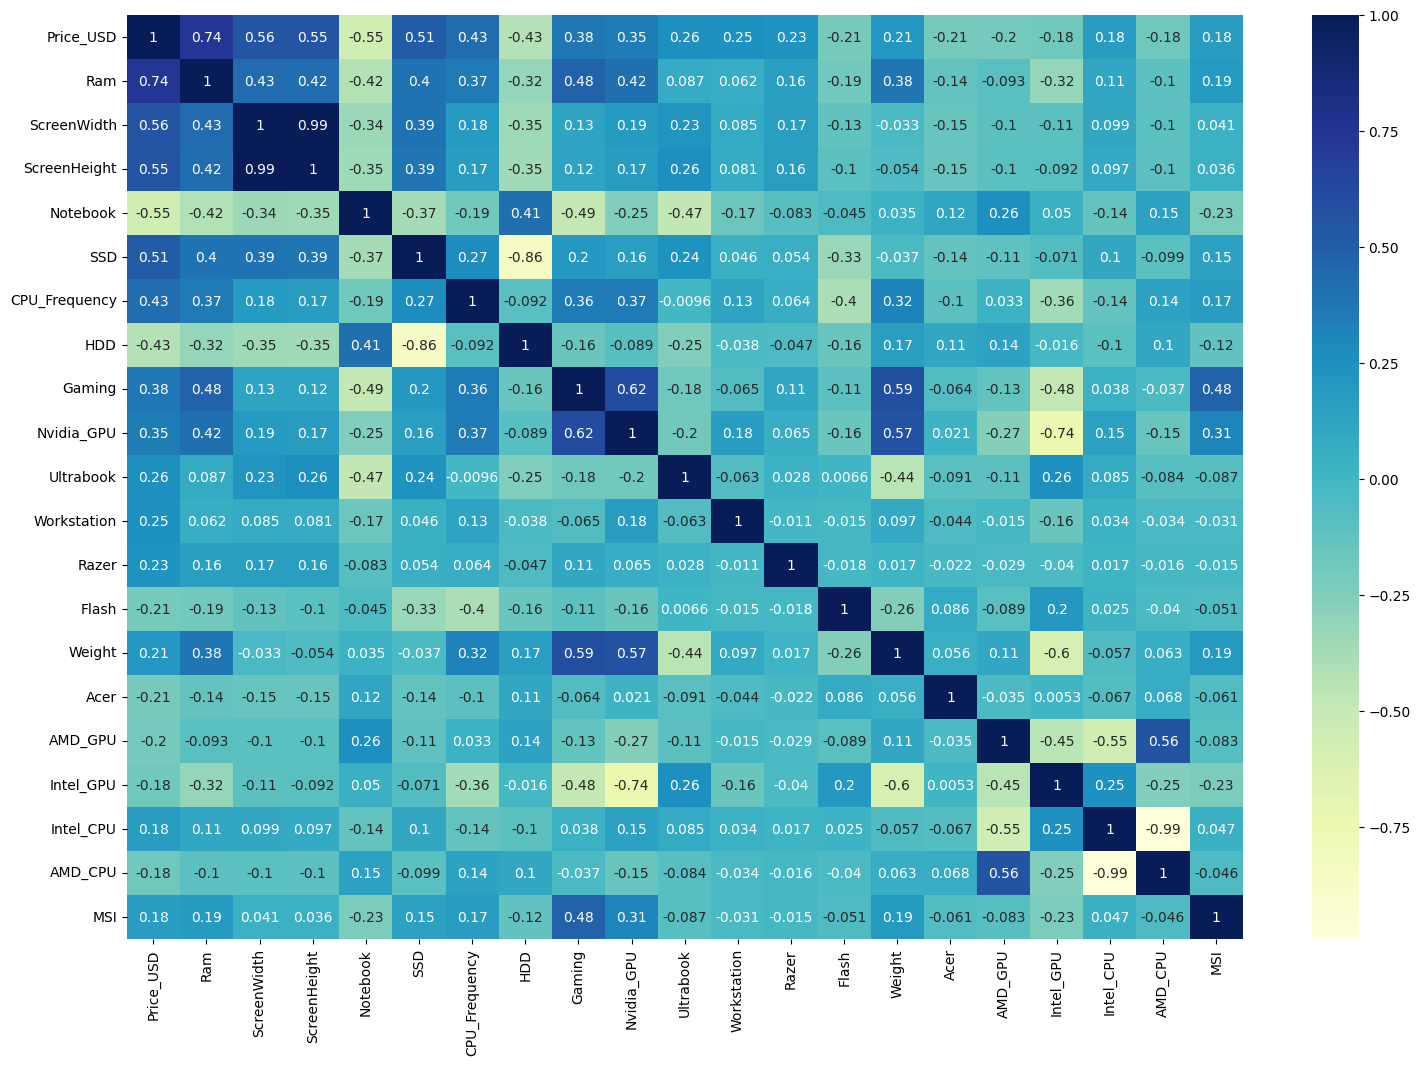

In [33]:
limited_df = df[selected_correlations]

plt.figure(figsize=(18,12))
sns.heatmap(limited_df.corr(), annot=True, cmap="YlGnBu")

This conlcludes the data prep/analytics portion of this demo. We will now train a random forest regressor on this limited_df.

In [38]:
test_size = 0.15

X, Y = limited_df.drop("Price_USD", axis=1), limited_df["Price_USD"] 
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=test_size)

In [39]:
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [40]:
forest = RandomForestRegressor()

forest.fit(X_train_scaled, Y_train)

RandomForestRegressor()

In [41]:
forest.score(X_test_scaled, Y_test)

0.7968393485001464

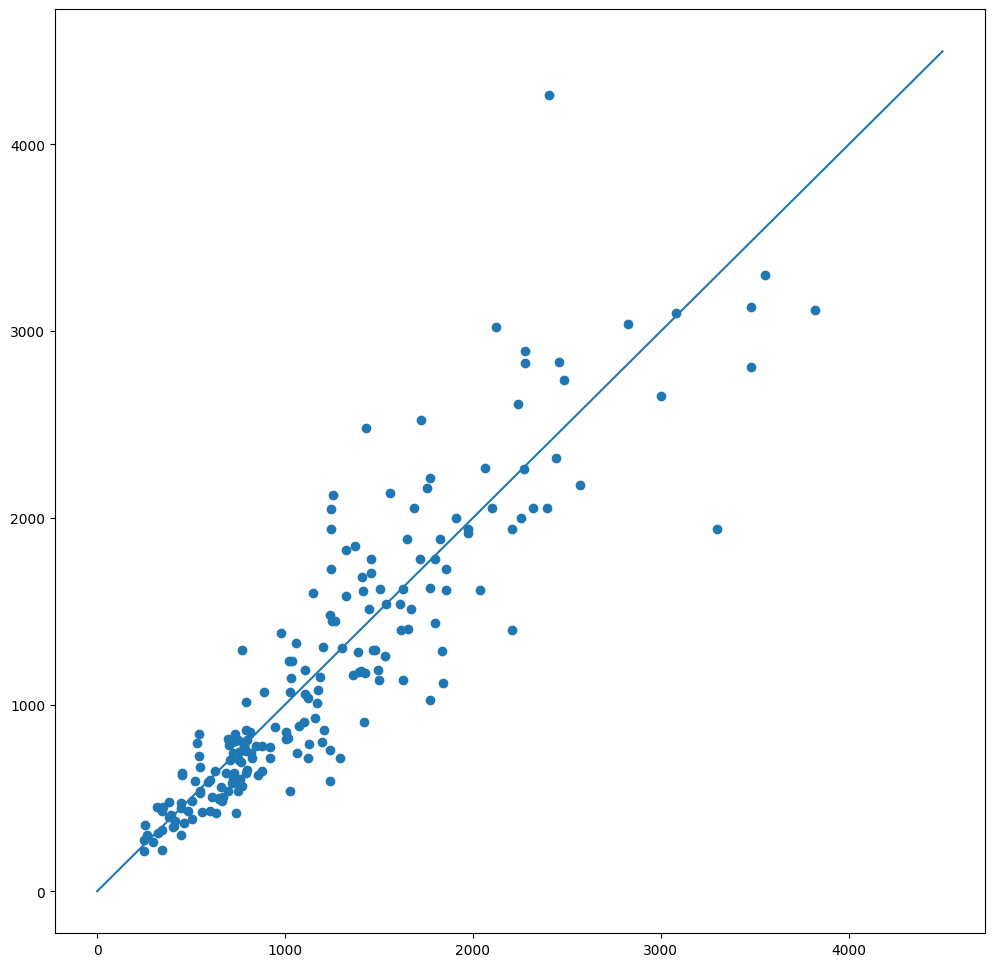

In [51]:
Y_predicted = forest.predict(X_test_scaled)

plt.figure(figsize=(12,12))
plt.scatter(Y_predicted, Y_test)
plt.plot(range(0,4500), range(0,4500))

In [53]:
X_test.iloc[0]

Index(['Ram', 'ScreenWidth', 'ScreenHeight', 'Notebook', 'SSD',
       'CPU_Frequency', 'HDD', 'Gaming', 'Nvidia_GPU', 'Ultrabook',
       'Workstation', 'Razer', 'Flash', 'Weight', 'Acer', 'AMD_GPU',
       'Intel_GPU', 'Intel_CPU', 'AMD_CPU', 'MSI'],
      dtype='object')

In [64]:
X_test.iloc[0]

Ram                     4
ScreenWidth          1366
ScreenHeight          768
Notebook             True
SSD                 False
CPU_Frequency         2.0
HDD                  True
Gaming              False
Nvidia_GPU          False
Ultrabook           False
Workstation         False
Razer               False
Flash               False
Weight           5.291095
Acer                 True
AMD_GPU             False
Intel_GPU            True
Intel_CPU            True
AMD_CPU             False
MSI                 False
Name: 739, dtype: object

In [66]:
# We now test a random laptop from an Amazon search for demonstration

AMAZON_TEST = {
    "Ram" : 4,
    "ScreenWidth" : 1366,
    "ScreenHeight" : 768,
    "Notebook" : False,
    "SSD" : True,
    "CPU_Frequency" : 2.8,
    "HDD" : False,
    "Gaming" : False,
    "Nvidia_GPU" : False,
    "Ultrabook" : False,
    "Workstation" : False,
    "Razer" : False,
    "Flash" : True,
    "Weight" : 2.7,
    "Acer" : False,
    "AMD_GPU" : False,
    "Intel_GPU" : True,
    "Intel_CPU" : False,
    "AMD_CPU" : False,
    "MSI" : False,
}
ACTUAL_PRICE = 79.99
# I clicked 'sort by price: low-to-high'

In [84]:
AMAZON_TEST_scaled = scaler.transform(pd.DataFrame([AMAZON_TEST]))
result1 = forest.predict(AMAZON_TEST_scaled)
print(ACTUAL_PRICE, result1, 100*abs(1- (result1/ACTUAL_PRICE)))

79.99 [1388.961] [1636.41830229]


In [86]:
X_another_scaled = scaler.transform([X_test.iloc[0]])
result2 = forest.predict(X_another_scaled)
print(Y_test.iloc[0], result2, 100*abs(1 - (result2/Y_test.iloc[0])))

443.66400000000004 [446.188032] [0.5689062]


c:\Users\Jim\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
